In [1]:
import sys
sys.path.append('../')
from util.benchmarking import *
from quantum.hamiltonians import heisenberg
from quantum.time_evolution import apply_gates,generate_swap_gate
def random_tensor(*args, a=-.5, b=1, dtype=np.complex128):
        output = a + (b - a) * np.random.rand(*args).astype(dtype)
        output /= np.linalg.norm(output)
        return output

Using C++ implementation for incQR


In [18]:
def fixed_synth_tensor_experiment(mpo,mps,baseline,bond_dims,names,a=-.5,b=1,highres=False,return_data=False,
                                  fit_sweeps=8,sketch_increment=10,sketch_dim=10):    
    times = {name: [] for name in names}
    accs = {name: [] for name in names}

    baseline.canonize()
    print(baseline.norm())
    
    column_names = ['Bond Dimension'] + [f'{name} {metric}' for name in names for metric in ['Time', 'Accuracy']]
    results_df = pd.DataFrame(columns=column_names)
    display(results_df)

    for bond_dim in bond_dims:
        for name in names:
            start = time.time()
            if name == 'naive':
                result = mps_mpo_blas(mps, mpo, stop=FixedDimension(bond_dim),round_type = "dass_blas")
            elif name == 'rand_then_orth':
                result = mps_mpo_blas(mps, mpo, stop=FixedDimension(bond_dim),round_type = "rand_then_orth_blas",final_round=False)
            elif name == 'nyst':
                result = mps_mpo_blas(mps, mpo, stop=FixedDimension(bond_dim),round_type = "nystrom_blas",final_round=False)
            elif name == 'random+oversample':
                    result = random_contraction_inc(mpo, mps, stop=FixedDimension(max(int(np.ceil(1.75*bond_dim)),bond_dim+10)), accuracychecks=False, 
                                                    finalround=FixedDimension(bond_dim), sketchincrement=sketch_increment, sketchdim=sketch_dim)
            elif name == 'random':
                result = random_contraction_inc(mpo, mps, stop=FixedDimension(bond_dim), accuracychecks=False, 
                                              finalround=None,sketchincrement=sketch_increment,sketchdim=sketch_dim)
            elif name == 'density':
                result = density_matrix(mpo, mps,stop=FixedDimension(bond_dim))
            elif name == 'zipup':
                result = zipup(mpo, mps, stop=FixedDimension(bond_dim),finalround=None)
            elif name == 'fit':
                result = fit(mpo, mps, max_sweeps=fit_sweeps,stop=FixedDimension(bond_dim),guess="input")#guess="input")
            elif name == "fit2":
                result = fit(mpo, mps, max_sweeps=2,stop=FixedDimension(bond_dim),guess="input")
            elif name == "fit10":
                result = fit(mpo, mps, max_sweeps=10,stop=FixedDimension(bond_dim),guess="input")
            else:
                print("Invalid algorithm choice for ", name, " review your inputted algorithm names")
                return
            times[name].append(time.time() - start)
            accs[name].append((baseline - result).norm() / baseline.norm())

        #Data Frame population
        new_row_data = {'Bond Dimension': bond_dim}
        for name in names:
            new_row_data[f'{name} Time'] = times[name][-1]  
            new_row_data[f'{name} Accuracy'] = accs[name][-1]  
        new_row_df = pd.DataFrame([new_row_data]) 
        results_df = pd.concat([results_df, new_row_df], ignore_index=True)
        clear_output(wait=True)
        display(results_df)
        
    if highres:
         # High resolution separate plots
        plt.figure( dpi=400)
        plot_times(names, bond_dims, times)
        plt.tight_layout()
        plt.grid(True)
        plt.show()

        plt.figure( dpi=400)
        plot_accuracy(names, bond_dims, accs)
        plt.tight_layout()
        plt.grid(True)

        plt.show()
    else:
        # Standard multi-plot
        fig, axs = plt.subplots(1, 2, figsize=(12, 5)) 
        plot_times(names, bond_dims, times, ax=axs[0])
        plot_accuracy(names, bond_dims, accs, ax=axs[1])
    if return_data:
        return times,accs

In [3]:
def tensor_product_mps(states):
    return MPS([np.reshape(states[0],(len(states[0]),1))] + [np.reshape(states[i],(1,len(states[i]),1)) for i in range (1,len(states)-1)] + [np.reshape(states[-1],(1,len(states[-1])))])



def partially_entangled_state(N, d, X, entanglement_ratio=2, dtype=np.complex128, random_tensor=np.random.randn):
    entangled_sites = N // entanglement_ratio
    non_entangled_sites = N - entangled_sites

    # Tensor product structure
    states = [random_tensor(d).astype(dtype) for _ in range(non_entangled_sites)]

    # Transition point
    states.append(random_tensor(1, d, X).astype(dtype))

    # Random structure
    states += [random_tensor(X, d, X).astype(dtype) for _ in range(entangled_sites, N - 1)]
    states.append(random_tensor(X, d).astype(dtype))

    return MPS(
        [np.reshape(states[0], (d, 1))] +
        [np.reshape(states[i], (1, d, 1)) for i in range(1, non_entangled_sites)] +
        [np.reshape(states[non_entangled_sites], (1, d, X))] +
        [np.reshape(states[i], (X, d, X)) for i in range(non_entangled_sites + 1, N - 1)] +
        [np.reshape(states[-1], (X, d))]
    )

In [ ]:
# a = -.5 #100,60,60 breaks fitting 
# chi = 50
# N = 101
# d=2
# # num_summands=25
# dtype= np.complex128

# def my_random_tensor(*args, a=a, b=1, dtype=dtype):
#         output = a + (b - a) * np.random.rand(*args).astype(dtype)
#         output /= np.linalg.norm(output)
#         return output

# print("Generating baseline contraction...")
# gates = [generate_swap_gate(d) for _ in range(2*N-3)]
# # gates = [generate_swap_gate(d) for _ in range(int(1.5*N))]
# # N34 = int(3*N/4)-1
# # rest = 2*N-3-2*N34
# # gates= [generate_swap_gate(d) for _ in range(N34)] + [np.eye(d**2).reshape(d,d,d,d) for _ in range(rest)] + [generate_swap_gate(d) for _ in range(N34)]
# identity = MPO.identity(d,N,1) 
# swap_mpo = apply_gates(identity, gates)
# swap_mpo.show()



# # mps = MPS.random_mps(N, chi, random_tensor=random_tensor,dtype=dtype)
# # mps = tensor_product_mps([np.random.randn(d) for _ in range(N)])
# # for i in range(num_summands-1):
# #     mps += tensor_product_mps([np.random.randn(d) for _ in range(N)])
# #     #mps +=  MPS.random_mps(N, chi, d=2,random_tensor=random_tensor,dtype=dtype)
# #     # mps.normalize()

# mps = partially_entangled_state(N,d,chi,entanglement_ratio=2,random_tensor=my_random_tensor)
# mps.canonize_left()

# # mps[mps.N//2] = np.einsum("XdY,dk->XkY", mps[mps.N//2], scipy.linalg.expm(1j * pauli_y * np.pi / 4))

# mps.show()
# baseline = mps_mpo_blas(mps, swap_mpo, stop=Cutoff(1e-12),round_type="dass_blas")
# baseline.show()


In [14]:
a = -.5 #100,60,60 breaks fitting 
# chi = 10
N = 101
d=2
# num_summands=25
dtype= np.complex128

def my_random_tensor(*args, a=a, b=1, dtype=dtype):
        output = a + (b - a) * np.random.rand(*args).astype(dtype)
        output /= np.linalg.norm(output)
        return output



from quantum.hamiltonians import long_range_XY_model
from quantum.dmrg import dmrg2

mpo = long_range_XY_model(N,1,1.5)
mps = MPS.random_mps(N, 2)
mps, _  = dmrg2(mpo, mps, sweeps=2, stop=Cutoff(1e-8))
mps.canonize_left()

# mps[mps.N//2] = np.einsum("XdY,dk->XkY", mps[mps.N//2], scipy.linalg.expm(1j * pauli_y * np.pi / 4))

mps.show()
baseline = mps_mpo_blas(mps, mpo, stop=Cutoff(1e-15),round_type="dass_blas")
baseline.show()

100%|██████████| 397/397 [00:51<00:00,  7.78it/s] 


    │2│4│8│16│32│32│32│32│32│32│32│32│32│32│32│32│32│32│32│32│32│32│32│32│    
... ●-<-<-<--<--<--<--<--<--<--<--<--<--<--<--<--<--<--<--<--<--<--<--<--< ...
                                 ...                                  
    32│32│32│32│32│32│32│32│32│32│32│32│32│32│32│32│32│32│32│32│32│32│32│3    
... --<--<--<--<--<--<--<--<--<--<--<--<--<--<--<--<--<--<--<--<--<--<--<- ...
                                 ...                                  
    2│32│32│32│32│32│32│32│32│32│32│32│32│32│32│32│32│32│32│32│32│32│32│32    
... -<--<--<--<--<--<--<--<--<--<--<--<--<--<--<--<--<--<--<--<--<--<--<-- ...
                                 ...                                  
    │32│32│32│32│32│32│32│32│32│32│32│32│32│32│32│32│32│32│32│32│32│32│32│    
... <--<--<--<--<--<--<--<--<--<--<--<--<--<--<--<--<--<--<--<--<--<--<--< ...
                                 ...                                  
    32│32│16│8│4│2│
    --<--<--<-<-<-■
    │2│4│8│16│32│64│128│256│506│813│773│810│

In [15]:
round_left(baseline, type="dass_blas")
baseline.show()

    │2│4│8│16│32│64│128│256│506│813│773│810│781│807│782│806│785│802│786│79    
... ●-<-<-<--<--<--<━━━<━━━<━━━<━━━<━━━<━━━<━━━<━━━<━━━<━━━<━━━<━━━<━━━<━━ ...
                                 ...                                  
    9│789│798│791│796│797│798│802│802│805│808│810│811│813│814│817│816│819│    
... ━<━━━<━━━<━━━<━━━<━━━<━━━<━━━<━━━<━━━<━━━<━━━<━━━<━━━<━━━<━━━<━━━<━━━< ...
                                 ...                                  
    819│821│820│822│821│823│822│823│822│826│822│827│821│826│821│825│821│82    
... ━━━<━━━<━━━<━━━<━━━<━━━<━━━<━━━<━━━<━━━<━━━<━━━<━━━<━━━<━━━<━━━<━━━<━━ ...
                                 ...                                  
    5│819│823│818│823│816│821│814│820│811│817│808│814│804│809│799│803│793│    
... ━<━━━<━━━<━━━<━━━<━━━<━━━<━━━<━━━<━━━<━━━<━━━<━━━<━━━<━━━<━━━<━━━<━━━< ...
                                 ...                                  
    798│787│791│779│785│768│776│757│764│743│751│728│738│711│720│697│698│70    
... ━

### Ready to run for 100 

,Bond Dimension,fit Time,fit Accuracy,fit10 Time,fit10 Accuracy,random Time,random Accuracy
0,10,3.57e-01,1.00e+00,2.71e+00,1.00e+00,1.38e-01,2.62e-01
1,20,6.55e-01,1.00e+00,4.83e+00,1.00e+00,2.54e-01,3.43e-02
2,30,7.33e-01,1.00e+00,6.70e+00,1.00e+00,2.61e-01,6.15e-03
3,40,1.16e+00,1.00e+00,9.89e+00,1.00e+00,3.66e-01,7.74e-04
4,50,1.38e+00,1.00e+00,1.37e+01,1.00e+00,5.19e-01,3.27e-04
5,60,1.65e+00,1.00e+00,1.68e+01,1.00e+00,6.90e-01,1.89e-04
6,70,2.04e+00,1.00e+00,2.20e+01,1.00e+00,7.75e-01,1.15e-04
7,80,2.17e+00,1.00e+00,2.56e+01,1.00e+00,9.31e-01,7.17e-05
8,90,2.44e+00,1.00e+00,3.09e+01,1.00e+00,9.93e-01,4.94e-05
9,100,2.40e+00,1.00e+00,3.51e+01,1.00e+00,1.17e+00,3.25e-05


<Figure size 2560x1920 with 0 Axes>

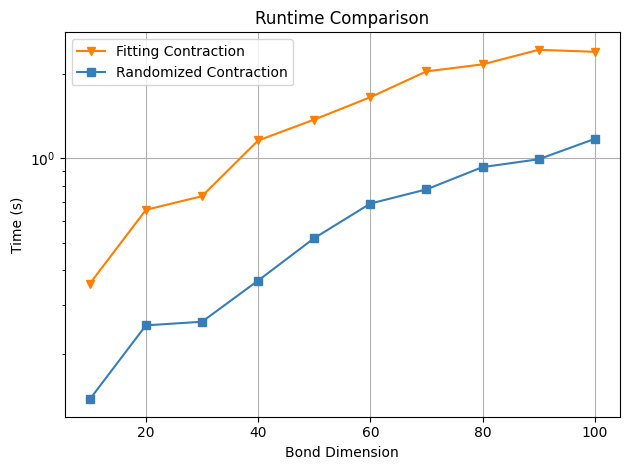

<Figure size 2560x1920 with 0 Axes>

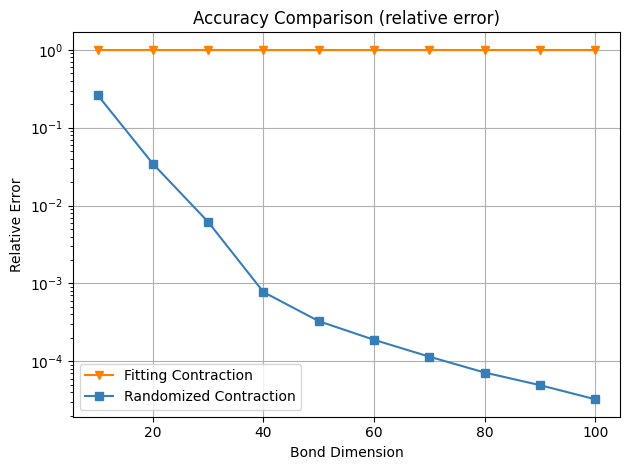

In [19]:
bond_dims = range(10, 110, 10) #Range 5-50
# names = ['naive_blas','blasinc','zipup','fit','density']#'density']#,'zipup_blas','density']

# names = ['fit','fit10','naive','random',"random+oversample"]#'density']#,'zipup_blas','density']
names = ['fit','fit10','random']#'density']#,'zipup_blas','density']

times,accs = fixed_synth_tensor_experiment(mpo,mps,baseline,bond_dims,names,a,highres=True,return_data=True,fit_sweeps=1)

<Axes: xlabel='Bond Dimension', ylabel='Relative Error'>

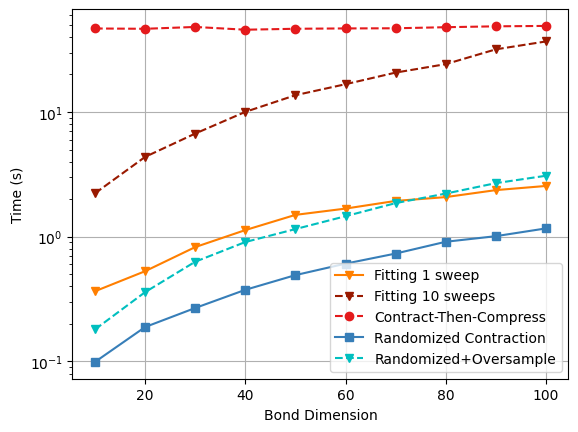

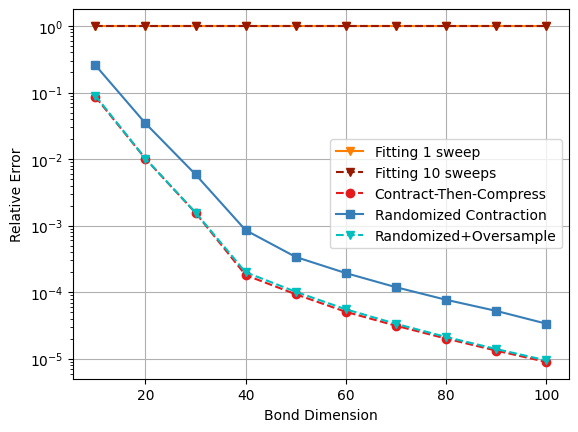

In [10]:
def plot_times(test_names, var, times_data, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
   
    palette = sns.color_palette("Set1", 6)  
    plot_styles = {
        'naive': (palette[0], 'o', 'Contract-Then-Compress', '--'),  # First color, circle marker, dashed line
        'random': (palette[1], 's', 'Randomized Contraction', '-'),  # Second color, square marker, solid line
        'zipup': (palette[2], 'D', 'Zip-up Contraction', '-'),       # Third color, diamond marker, solid line
        'density': (palette[3], '^', 'Density Matrix Contraction', '-'), # Fourth color, triangle up marker, solid line
        'fit': (palette[4], 'v', 'Fitting 1 sweep', '-'),        # Fifth color, triangle down marker, solid line
        'fit2': (darken_color(palette[4], 0.2), 'v', 'Fitting 2 sweeps', '-'),  # Darker version of fifth color
        'fit10': (darken_color(palette[4], 0.4), 'v', 'Fitting 10 sweeps', '--'),  # Darker version of fifth color
        'random+oversample': ('c', 'v', 'Randomized+Oversample', '--'),

        'rand_then_orth': ('g', '^', 'Rand_then_orth Contraction', '--'),
        'nyst': ('b', 'v', 'Nystrom Contraction', '--'),
    }

    for name in test_names:
        if name in plot_styles and name in times_data:
            color, marker, label, linestyle = plot_styles[name]
            ax.plot(var, times_data[name], color=color, marker=marker, label=label, markersize=6, linewidth=1.5, linestyle=linestyle)
            
    # ax.set_title ("Runtime Comparison")
    ax.set_yscale('log')
    ax.grid()
    ax.set_xlabel('Bond Dimension')
    ax.set_ylabel('Time (s)')
    ax.legend()
    return ax


import matplotlib.colors as mcolors
def darken_color(color, factor=0.1):
    color_rgb = mcolors.to_rgb(color)
    darkened_color = tuple(max(0, c - factor) for c in color_rgb)
    return darkened_color


def plot_accuracy(test_names, var, accuracy_data, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
        
    palette = sns.color_palette("Set1", 6)  
    plot_styles = {
        'naive': (palette[0], 'o', 'Contract-Then-Compress', '--'),  # First color, circle marker, dashed line
        'random': (palette[1], 's', 'Randomized Contraction', '-'),  # Second color, square marker, solid line
        'zipup': (palette[2], 'D', 'Zip-up Contraction', '-'),       # Third color, diamond marker, solid line
        'density': (palette[3], '^', 'Density Matrix Contraction', '-'), # Fourth color, triangle up marker, solid line
        'fit': (palette[4], 'v', 'Fitting 1 sweep', '-'),        # Fifth color, triangle down marker, solid line
        'fit2': (darken_color(palette[4], 0.2), 'v', 'Fitting 2 sweeps', '-'),  # Darker version of fifth color
        'fit10': (darken_color(palette[4], 0.4), 'v', 'Fitting 10 sweeps', '--'),  # Darker version of fifth color
        'random+oversample': ('c', 'v', 'Randomized+Oversample', '--'),
        'rand_then_orth': ('g', '^', 'Rand_then_orth Contraction', '--'),
        'nyst': ('b', 'v', 'Nystrom Contraction', '--'),
    }

    for name in test_names:
        if name in plot_styles and name in accuracy_data:
            color, marker, label, linestyle = plot_styles[name]
            ax.plot(var, accuracy_data[name], color=color, marker=marker, label=label, markersize=6, linewidth=1.5, linestyle=linestyle)
      
    # ax.set_title("Accuracy Comparison (relative error)")
    ax.set_yscale('log')
    ax.grid()
    ax.set_xlabel('Bond Dimension')
    ax.set_ylabel('Relative Error')
    ax.legend()
    return ax
plot_times(names,bond_dims,times)
plot_accuracy(names,bond_dims,accs)

/var/folders/6k/g8w9pg6j4b3b_76hhg422g440000gn/T/ipykernel_36629/292128584.py:15: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.3)


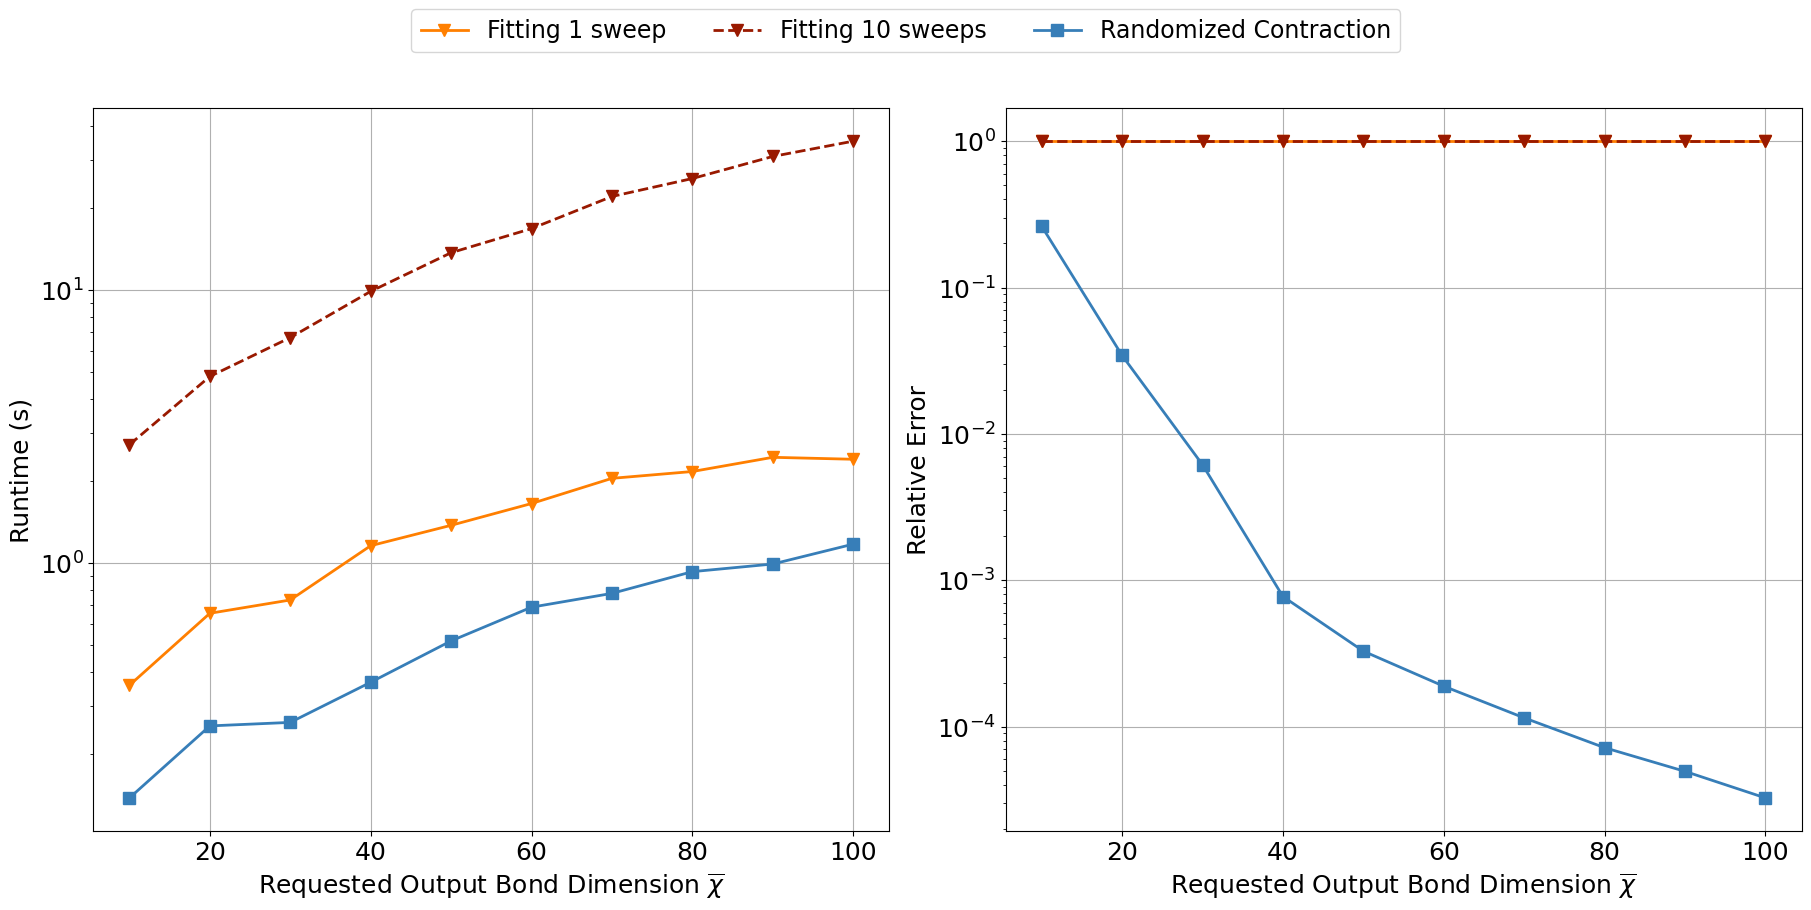

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.colors as mcolors

def plot_combined(test_names, var, mean_times_data , mean_acc_data):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8), constrained_layout=True)
    
    # Global style variables
    global_font_size = 18
    global_marker_size = 8
    global_line_width = 2
    
    # Update space between the plots
    plt.subplots_adjust(wspace=0.3)

    # Helper function to darken colors
    def darken_color(color, factor=0.1):
        color_rgb = mcolors.to_rgb(color)
        return tuple(max(0, c - factor) for c in color_rgb)

    # Define plot styles
    palette = sns.color_palette("Set1", 6)
    plot_styles = {
        'naive': (palette[0], 'o', 'Contract-Then-Compress', '--'),  # First color, circle marker, dashed line
        'random': (palette[1], 's', 'Randomized Contraction', '-'),  # Second color, square marker, solid line
        'zipup': (palette[2], 'D', 'Zip-up Contraction', '-'),       # Third color, diamond marker, solid line
        'density': (palette[3], '^', 'Density Matrix Contraction', '-'), # Fourth color, triangle up marker, solid line
        'fit': (palette[4], 'v', 'Fitting 1 sweep', '-'),        # Fifth color, triangle down marker, solid line
        'fit2': (darken_color(palette[4], 0.2), 'v', 'Fitting 2 sweeps', '-'),  # Darker version of fifth color
        'fit10': (darken_color(palette[4], 0.4), 'v', 'Fitting 10 sweeps', '--'),  # Darker version of fifth color
        'random+oversample': ('c', 'v', 'Randomized+Oversample', '--'),
        'rand_then_orth': ('g', '^', 'Rand_then_orth Contraction', '--'),
        'nyst': ('b', 'v', 'Nystrom Contraction', '--'),
    }
    # Plot times with error bands
    def plot_times(ax):
        for name in test_names:
            if name in plot_styles and name in mean_times_data:
                color, marker, label, linestyle = plot_styles[name]
                mean_values = np.array(mean_times_data[name])
                #std_values = np.array(std_times_data[name])

                ax.plot(var, mean_values, color=color, marker=marker, label=label,
                        markersize=global_marker_size, linewidth=global_line_width,
                        linestyle=linestyle, markerfacecolor='none' if name == 'naive' else color,
                        markeredgewidth=1)
                #ax.fill_between(var, mean_values - std_values, mean_values + std_values,
                                #color=color, alpha=0.3)

        ax.set_yscale('log')
        ax.grid(True)
        ax.set_xlabel(r'Requested Output Bond Dimension $\overline{\chi}$', fontsize=global_font_size)
        ax.set_ylabel('Runtime (s)', fontsize=global_font_size)
        ax.tick_params(axis='both', which='major', labelsize=global_font_size)

    # Plot accuracy with error bands
    def plot_accuracy(ax):
        for name in test_names:
            if name in plot_styles and name in mean_acc_data:
                color, marker, label, linestyle = plot_styles[name]
                mean_values = np.array(mean_acc_data[name])
                #std_values = np.array(std_acc_data[name])
                if name == 'naive':
                    ax.plot(var, mean_values, color=color, marker=marker, label=label, markersize=16, 
                            linewidth=global_line_width, linestyle=linestyle, markerfacecolor='none', markeredgewidth=1, alpha=1)
                else:
                    ax.plot(var, mean_values, color=color, marker=marker, label=label,
                        markersize=global_marker_size, linewidth=global_line_width,
                        linestyle=linestyle, markerfacecolor='none' if name == 'naive' else color,
                        markeredgewidth=1)
                #ax.fill_between(var, mean_values - std_values, mean_values + std_values,
                              #  color=color, alpha=0.3)

        ax.set_yscale('log')
        ax.grid(True)
        ax.set_xlabel(r'Requested Output Bond Dimension $\overline{\chi}$', fontsize=global_font_size)
        ax.set_ylabel('Relative Error', fontsize=global_font_size)
        ax.tick_params(axis='both', which='major', labelsize=global_font_size)

    # Generate the two subplots
    plot_times(ax1)
    plot_accuracy(ax2)

    # Shared legend below the plots
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', fontsize=17, ncol=4, bbox_to_anchor=(0.5, 1.05))

    return fig

bond_dims = range(10, 110, 10) #Range 5-50
# names = ['naive_blas','blasinc','zipup','fit','density']#'density']#,'zipup_blas','density']

names = ['fit','fit10','naive','random',"random+oversample"]#'density']#,'zipup_blas','density']
# Plot the combined figure
fig = plot_combined(names, bond_dims, times, accs,)
plt.show()

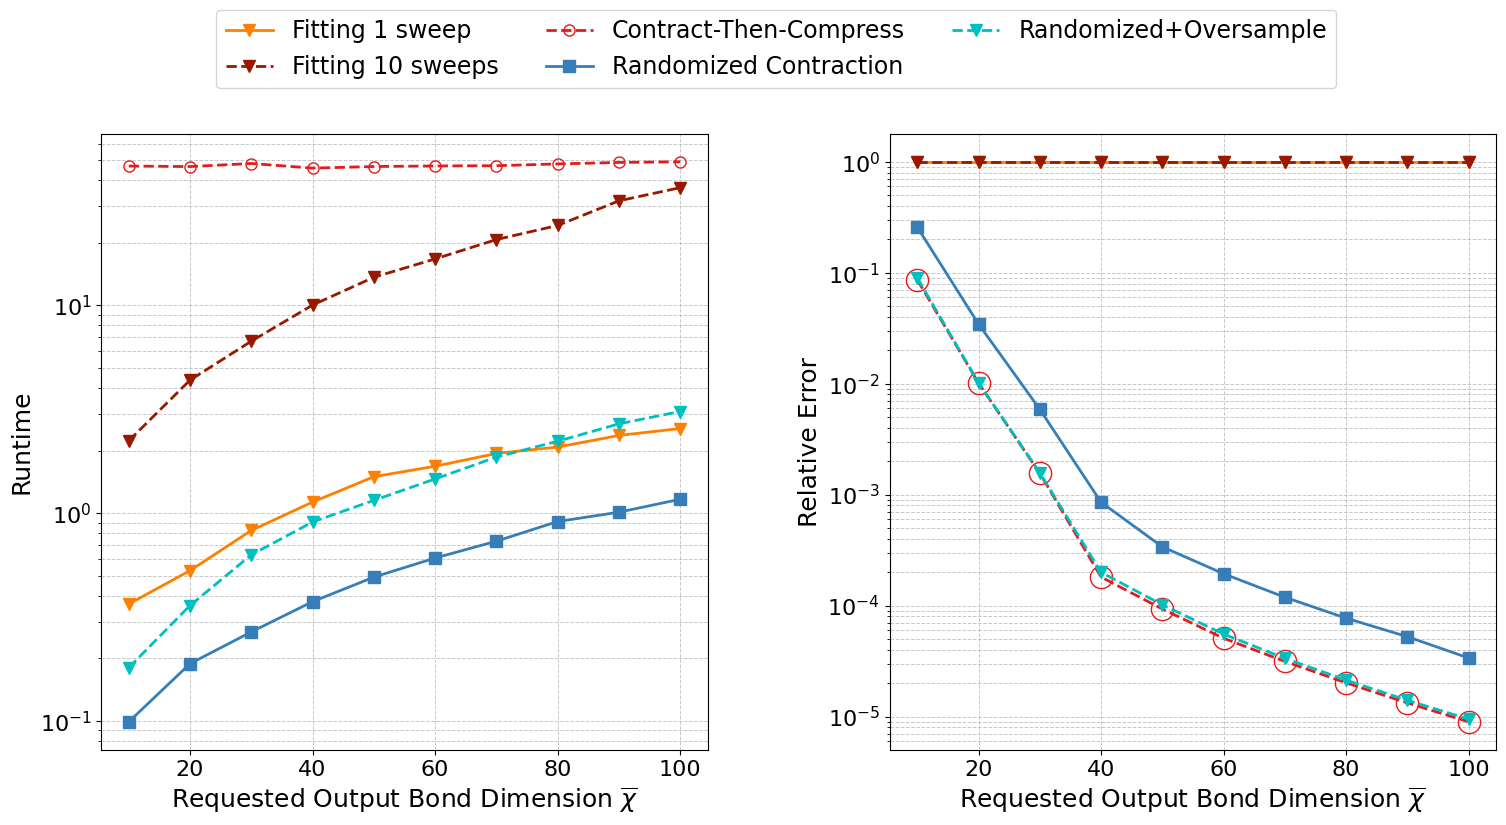

In [12]:
# Global settings for consistency
global_font_size = 18
global_marker_size = 8
global_line_width = 2

# Define plot styles globally for reuse
 # Helper function to darken colors
def darken_color(color, factor=0.1):
    color_rgb = mcolors.to_rgb(color)
    return tuple(max(0, c - factor) for c in color_rgb)

# Define plot styles
palette = sns.color_palette("Set1", 6)
PLOT_STYLES = {
    'naive': (palette[0], None, 'o', 'Contract-Then-Compress', '--'),
    'random': (palette[1], None, 's', 'Randomized Contraction', '-'),
    'zipup': (palette[2], None, 'D', 'Zip-up Contraction', '-'),
    'density': (palette[3], None, '^', 'Density Matrix Contraction', '-'),
    'fit': (palette[4], None, 'v', 'Fitting 1 sweep', '-'),
    'fit2': (darken_color(palette[4], 0.2), None, 'v', 'Fitting 2 sweeps', '-'),
    'fit10': (darken_color(palette[4], 0.4), None, 'v', 'Fitting 10 sweeps', '--'),
    'random+oversample': ('c', None, 'v', 'Randomized+Oversample', '--'),
}

def plot_graph(test_names, cutoffs, data, y_label, title, ax, y_scale='log',naive_marker_flag=True):
    """Helper function to plot a single graph with conditional formatting and fill_between for std."""

    for name in test_names:
        if name in PLOT_STYLES and name in data:
            palette_name, color_idx, marker, label, linestyle = PLOT_STYLES[name]
            color = sns.color_palette(palette_name, 6)[color_idx] if color_idx is not None else palette_name

            # Extract the mean and std data for fill_between
            mean_values = data[name]
            # std_values = std_data[name] if std_data and name in std_data else np.zeros_like(mean_values)

            if name == 'naive':
                # Plot 'naive' with custom styling
                if naive_marker_flag:
                    ax.plot(
                        cutoffs, mean_values, color=color, marker=marker, label=label,
                        markersize=16, linewidth=global_line_width, linestyle=linestyle,
                        markerfacecolor='none', markeredgewidth=1, alpha=1
                    )
                else:
                    ax.plot(
                        cutoffs, mean_values, color=color, marker=marker, label=label,
                        markersize=8, linewidth=global_line_width, linestyle=linestyle,
                        markerfacecolor='none', markeredgewidth=1, alpha=1
                    )
            else:
                # Plot other lines with default settings
                ax.plot(
                    cutoffs, mean_values, color=color, marker=marker, label=label,
                    markersize=global_marker_size, linewidth=global_line_width, linestyle=linestyle
                )

            # # Add fill_between for std
            # ax.fill_between(
            #     cutoffs,
            #     mean_values - std_values, mean_values + std_values,
            #     color=color, alpha=0.2
            # )

    ax.set_yscale(y_scale)
    ax.set_xlabel(r'Requested Output Bond Dimension $\overline{\chi}$', fontsize=global_font_size)
    ax.set_ylabel(y_label, fontsize=global_font_size)
    ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

    # Adjust tick parameters
    ax.tick_params(axis='both', which='major', labelsize=global_font_size - 2)

def combined_plot(test_names, cutoff_values, mean_times, 
                  mean_acc):
    """Function to create a combined plot with three subplots and a shared top legend."""
    fig, axes = plt.subplots(1, 2, figsize=(18, 8), constrained_layout=False)

    # Adjust layout for tighter spacing
    plt.subplots_adjust(wspace=.3)

    # Plot each graph on the respective axis
    plot_graph(test_names, cutoff_values, mean_times, 'Runtime', None, axes[0],naive_marker_flag=False)
    plot_graph(test_names, cutoff_values, mean_acc, 'Relative Error', None, axes[1])
    # plot_graph(test_names, cutoff_values, mean_bond_dims, 'Bond Dimension', None, axes[2],y_scale="linear",)

    # Collect legend handles and labels from one of the axes
    handles, labels = axes[0].get_legend_handles_labels()

    # Create a shared legend at the top of the figure
    fig.legend(
        handles, labels, loc='upper center', fontsize=global_font_size - 1, ncol=3, 
        bbox_to_anchor=(0.5, 1.05)
    )

    # Show the plot
    plt.show()
# fig = plot_combined(names, bond_dims, times, accs,)
combined_plot(names,bond_dims,times,accs)
    

### Old code 